Image segmentaion involves dividing an image into **multiple regions**, each of which corresponds to a meaningful object or part of the image. For example one might want to divide an image into a forground regions of interest and background. We will train a **UNet** model to segment nuclei in histopathological images.  These types of images can be used to are often used to diagnose cancer since nuclei size and shape are affected by disease. 
### Import
We start out by importing the necessary python modules

In [1]:
## Standard Library
import os

## External Libraries
try:
    import torch, torchvision, skimage
except:
    # Install packages if not available
    !conda install -y -c pytorch pytorch
    !conda install -y -c pytorch torchvision
    !conda install -y -c anaconda scikit-image
    import torch, torchvision, skimage

import numpy as np
import torch.nn as nn
from torchvision import transforms
from torch.autograd import Variable
import torch.nn.functional as functional
from torch.utils.data import Dataset, DataLoader
from skimage import io
import matplotlib.pyplot as plt

Solving environment: ...working... done

# All requested packages already installed.

Retrieving notices: ...working... done




==> WARNING: A newer version of conda exists. <==
  current version: 4.14.0
  latest version: 24.9.2

Please update conda by running

    $ conda update -n base -c defaults conda






==> WARNING: A newer version of conda exists. <==
  current version: 4.14.0
  latest version: 24.9.2

Please update conda by running

    $ conda update -n base -c defaults conda





Solving environment: ...working... done

# All requested packages already installed.

Retrieving notices: ...working... done




==> WARNING: A newer version of conda exists. <==
  current version: 4.14.0
  latest version: 24.9.2

Please update conda by running

    $ conda update -n base -c defaults conda




Solving environment: ...working... failed with initial frozen solve. Retrying with flexible solve.
Solving environment: ...working... failed with repodata from current_repodata.json, will retry with next repodata source.
Solving environment: ...working... done

## Package Plan ##

  environment location: C:\Users\bains\anaconda3\envs\gateway

  added / updated specs:
    - scikit-image


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    blosc-1.21.0               |       h19a0ad4_1         172 KB  anaconda
    ca-certificates-2024.9.24  |       haa95532_0         171 KB  anaconda
    certifi-2024.8.30          |  py310haa95532_0         165 KB  anaconda
    cfitsio-3.470              |       h2bbff1b_7         603 KB  anaconda
    charls-2.2.0               |       h6c2663c_0          93 KB  anaconda
    cytoolz-0.12.2             |  py310h2bbff1b_0         335 KB  anaconda
    dask-core-2

### Load Data
Here we load the dataset which comes from [Mahbod *et al* 2021](https://doi.org/10.1016/j.compbiomed.2021.104349). The training dataset contains **24** H&E stained histological images and corresponding manually segmented nuclei as masks.   It has also has an addional  **6** image-mask pairs testing.


In [3]:
try:
    ## Mount Google Drive if using Google Colab
    from google.colab import drive
    drive.mount('/content/gdrive/')
    data_dir = "gdrive/MyDrive/Nuclei128x128"
except:
    # Otherwise read from disk if using Anaconda
    data_dir = "./Nuclei128x128"

In [6]:
from PIL import Image

class SegImageDataset(Dataset):
    def __init__(self, data_dir, type_of_operation='train', transform=None):
        self.data_dir = data_dir
        self.type_of_operation = type_of_operation
        self.transform = transform
        self.image_dir = os.path.join(data_dir, type_of_operation, 'image')
        self.mask_dir = os.path.join(data_dir, type_of_operation, 'mask')
        self.images = os.listdir(self.image_dir)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_name = os.path.join(self.image_dir, self.images[idx])
        mask_name = os.path.join(self.mask_dir, self.images[idx])

        image = Image.open(img_name)
        mask = Image.open(mask_name)

        if self.transform:
            image = self.transform(image)
            mask = self.transform(mask)

        return image, mask

train_dataset = SegImageDataset(data_dir=data_dir, type_of_operation='train', transform=transforms.ToTensor())
test_dataset = SegImageDataset(data_dir=data_dir, type_of_operation='test', transform=transforms.ToTensor())
train_dataloader = DataLoader(train_dataset, batch_size=5,shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=False)


The i<sup>th</sup> image and segmentation in the training dataset can be accessed in the way shown below. Each image is and corresponding segmentation contain **128 x 128** pixels. The image is in color and contains **3** channels to represent red, green and blue.  The mask contains **1** channel as it only need to represent binary values

In [7]:
i = 0
img, mask = train_dataset[i]
print(img.shape)
print(mask.shape)

torch.Size([3, 128, 128])
torch.Size([1, 128, 128])


 * Use `displayImg` to **show three images** from the training dataset and their corresponding segmentation masks

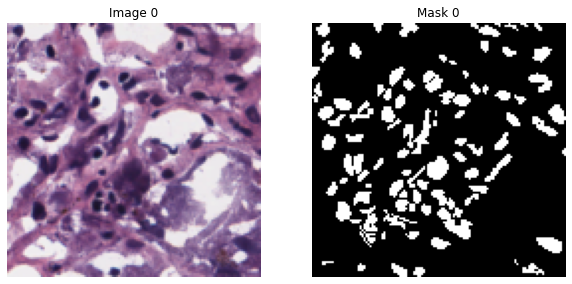

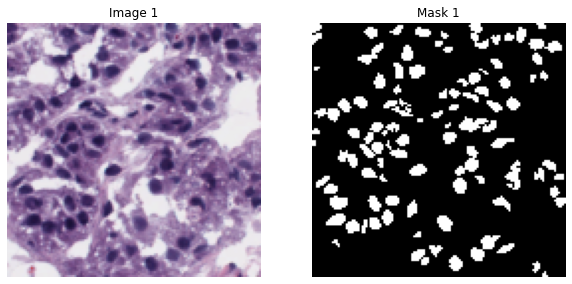

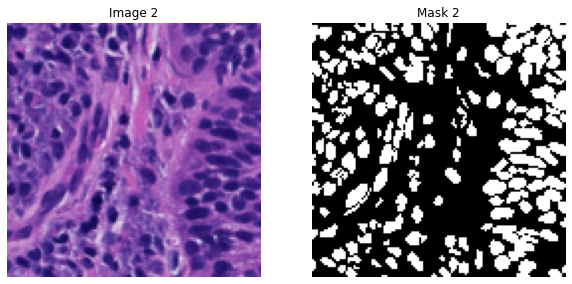

In [11]:

def displayImg(img):
  # Displays image stored in tensor
  if img.shape[0] == 3: # If color image rearrange dimensions to be (height, width, channels)
    plt.imshow(img.numpy().transpose(1,2,0))
  else:
    plt.imshow(img.numpy().squeeze(), cmap='gray')
  plt.axis("off") # Turn off axis labels and ticks

for i in [0, 1, 2]:  # Choose three image indices
    img, mask = train_dataset[i]

    plt.figure(figsize=(10, 5))  # Adjust figure size if needed

    plt.subplot(1, 2, 1)
    displayImg(img)
    plt.title(f"Image {i}")

    plt.subplot(1, 2, 2)
    displayImg(mask)
    plt.title(f"Mask {i}")

    plt.show()


The [**Dice score**] is used to assess how well the predicted segmentation $\hat{y}$ matches the actual segmentation $y$.  Intuitivly measures the *amount of overlap* between the predicted and actual segmentations.  Mathematically it is described as
$$
D(\hat{y},y) = \frac{2 | \hat{y} \cdot y |+s}{ |\hat{y} \cdot \hat{y}| + |y\cdot y| +s}
$$
Where $\cdot$ denotes dot product $s$ is an optional smooth parameter to avoid zero division errors.  The dice score is always in a range from 0.0 to 1.0 where 0.0 indicates no overlap and 1.0 indicates perfect overlap.  



In [57]:
def dice_score(y_hat, y, smooth=0):
    # Flatten to vectors
    y_hat = y_hat.view(-1)
    y = y.view(-1)
    
    overlap = (y_hat * y).sum()  # Element-wise multiplication and sum
    mag_pred = (y_hat * y_hat).sum() # Element-wise multiplication and sum
    mag_test = (y * y).sum() # Element-wise multiplication and sum
    D = (2. * overlap + smooth) / (mag_pred + mag_test + smooth)
    
    return D





Validating `dice_score` functon.
* Create two 30x30 torch tensors `v` and `w` using the `torch.zeros` function. [5 points]
 * Set $v_{ij}$ = 1 when $i,j \in [5,15)$ and  $v_{ij} = 0$ otherwise.
 * Set $w_{ij}$ = 1 when $i,j \in [10,20)$ and  $S_{ij} = 0$ otherwise.
* Use `displayImg` to show both tensors.   Notice how there 25% overlap between `v` and `w` [5 points]
* $D(\hat{y}, y)$ can be calculated using `dice_score(y_hat,y)`. Show that $D(v,v) = 1$ and $D(v,w) = 0.25$ [5 points]

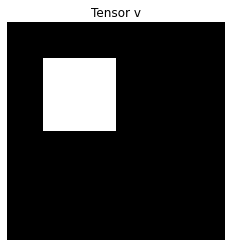

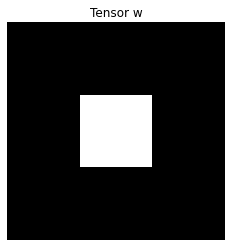

1.0
0.25


In [61]:
v = torch.zeros(30,30)
w = torch.zeros(30,30)


v[5:15, 5:15] = 1
w[10:20, 10:20] = 1

displayImg(v)
plt.title("Tensor v")
plt.show()

displayImg(w)
plt.title("Tensor w")
plt.show()


print(float(dice_score(v,v)))

print(float(dice_score(v,w)))



Our **Dice loss** is defined as:
$$
L(\hat{y}, y) = 1 - D(\hat{y}, y)
$$


In [53]:
class DiceLoss(nn.Module):
    def __init__(self):
      super().__init__()
      self.smooth = 1e-6

    def forward(self, y_hat, y):
      loss = 1 - dice_score(y_hat,y)
      return loss

print(DiceLoss()(v,v))
print(DiceLoss()(v,w))



0.0
0.75



We are going to use **U-Net** ([Ronneberger *et al* 2015](https://arxiv.org/abs/1505.04597)), a deep learning convolutional neural network (CNN) architecture designed for biomedical image segmentation.


In [54]:
# U-net class
class UNet(nn.Module):
  def __init__(self, in_channels, out_channels):
    super(UNet, self).__init__()
    self.encoder1 = self.conv_block(in_channels, 32)
    self.encoder2 = self.conv_block(32, 64)
    self.encoder3 = self.conv_block(64, 128)
    self.encoder4 = self.conv_block(128, 256)

    # Expanding path
    self.decoder3 = self.conv_block(256, 128)
    self.decoder2 = self.conv_block(128, 64)
    self.decoder1 = self.conv_block(64, 32)

    self.upsample3 = self.upsample(256, 128)
    self.upsample2 = self.upsample(128, 64)
    self.upsample1 = self.upsample(64 , 32)

    # Output layer
    self.output = nn.Conv2d(32, out_channels, kernel_size=1)
    self.maxpool = nn.MaxPool2d(2)
    self.activation = nn.Sigmoid()


  def conv_block(self, in_channels, out_channels):
    block = nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
        nn.ReLU(inplace = True),
        nn.Conv2d(out_channels,out_channels, kernel_size = 3, padding = 1),
        nn.ReLU(inplace = True) )
    return block

  def upsample(self, in_, out):
    return nn.Sequential(nn.ConvTranspose2d(in_, out, kernel_size=2, stride=2), nn.ReLU())

  def forward(self, x):
    encoder1_out = self.encoder1(x)
    encoder2_out = self.encoder2(self.maxpool(encoder1_out))
    encoder3_out = self.encoder3(self.maxpool(encoder2_out))
    encoder4_out = self.encoder4(self.maxpool(encoder3_out))

    # Expanding path
    decode3_out = self.decoder3(torch.cat((self.upsample3(encoder4_out), encoder3_out), 1))
    decode2_out = self.decoder2(torch.cat((self.upsample2(decode3_out), encoder2_out), 1))
    decode1_out = self.decoder1(torch.cat((self.upsample1(decode2_out), encoder1_out), 1))

    # Output
    output = self.activation(self.output(decode1_out))

    return output


Instructions/Parameters for Model:
* Define UNet `model` with 3 input and 1 output channel
* Define `lossFunction` object using `DiceLoss()`
* Define a Stochastic Gradianct Descent `optimizer` using `torch.optim.SGD` on the the model parameters with an appropriate learning rate


In [63]:

model = UNet(in_channels = 3,out_channels = 1)
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)

lossFunction = DiceLoss()

num_epochs = 100
epoch_loss = []

for epoch in range(num_epochs):
    batch_loss = []
    for img, mask in train_dataloader:
        # Zero the gradients
        optimizer.zero_grad()

        # Forward pass
        output = model(img)

        # Calculate the loss
        loss = lossFunction(output, mask)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        # Append the loss value to batch_loss
        batch_loss.append(loss.item())

    epoch_loss.append(np.mean(batch_loss))
    print(f"{epoch+1}/{num_epochs}. loss = {epoch_loss[-1]}")


1/100. loss = 0.4476378321647644
2/100. loss = 0.44724050760269163
3/100. loss = 0.44897468090057374
4/100. loss = 0.4512288570404053
5/100. loss = 0.44669413566589355
6/100. loss = 0.4458284854888916
7/100. loss = 0.45079177618026733
8/100. loss = 0.45073020458221436
9/100. loss = 0.4451179146766663
10/100. loss = 0.4446489930152893
11/100. loss = 0.44556732177734376
12/100. loss = 0.4420555830001831
13/100. loss = 0.4436841130256653
14/100. loss = 0.44770013093948363
15/100. loss = 0.4495232343673706
16/100. loss = 0.44591437578201293
17/100. loss = 0.4410825133323669
18/100. loss = 0.44842636585235596
19/100. loss = 0.44103924036026
20/100. loss = 0.4405898928642273
21/100. loss = 0.4370455265045166
22/100. loss = 0.4398414373397827
23/100. loss = 0.4425100326538086
24/100. loss = 0.43179835081100465
25/100. loss = 0.42817111015319825
26/100. loss = 0.4232962250709534
27/100. loss = 0.41705588102340696
28/100. loss = 0.4070661425590515
29/100. loss = 0.3952402830123901
30/100. loss 

Evaluating model on training dataset



Text(0, 0.5, 'loss')

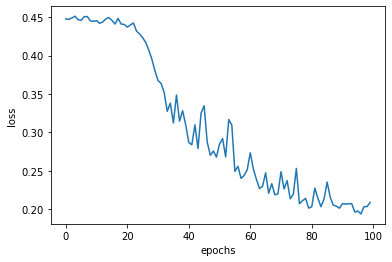

In [64]:

plt.figure()
plt.plot(epoch_loss)
plt.xlabel('epochs')
plt.ylabel('loss')



* For **3 images from training** dataset
 - Display image, predicted segmentation, and actual segmentation. Threshold prediction at 0.5

* Report the mean dice score across all images. 

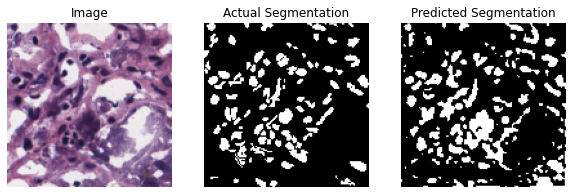

Dice Score for Image 0: 0.7142


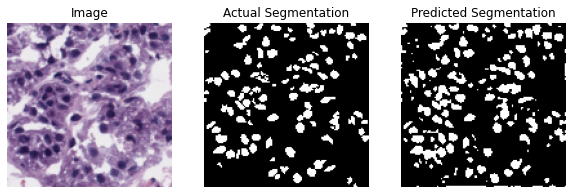

Dice Score for Image 1: 0.7971


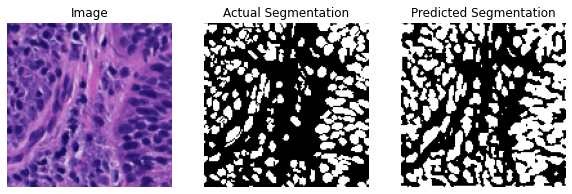

Dice Score for Image 2: 0.7924
Mean Dice Score across all 24 training images: 0.7569


In [67]:
# Select 3 random indices from the training dataset
indices = [0, 1, 2]  # You can change these indices

# Iterate over the selected indices
for i in indices:
    # Get the image and mask from the training dataset
    img, mask = train_dataset[i]

    # Make a prediction using the trained model
    with torch.no_grad():  # Disable gradient calculation during inference
        prediction = model(img.unsqueeze(0))  # Add batch dimension

    # Threshold the prediction at 0.5 and convert to float tensor
    predicted_mask = (prediction > 0.5).float()

    # Display the image, actual segmentation, and predicted segmentation
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 3, 1)
    displayImg(img)
    plt.title("Image")
    plt.subplot(1, 3, 2)
    displayImg(mask)
    plt.title("Actual Segmentation")
    plt.subplot(1, 3, 3)
    displayImg(predicted_mask.squeeze(0))  # Remove batch dimension
    plt.title("Predicted Segmentation")
    plt.show()

    # Calculate and display the Dice score
    dice = dice_score(predicted_mask, mask)
    print(f"Dice Score for Image {i}: {dice:.4f}")

# Calculate the mean Dice score across all 24 training images
total_dice = 0
for i in range(len(train_dataset)):
    img, mask = train_dataset[i]
    with torch.no_grad():
        prediction = model(img.unsqueeze(0))
    predicted_mask = (prediction > 0.5).float()
    total_dice += dice_score(predicted_mask, mask)

mean_dice = total_dice / len(train_dataset)
print(f"Mean Dice Score across all 24 training images: {mean_dice:.4f}")


For each of the **6 images in the test** dataset
- Display image, predicted segmentation, and actual segmentation. Threshold prediction at 0.5

Then report the mean dice score across all 6 test images

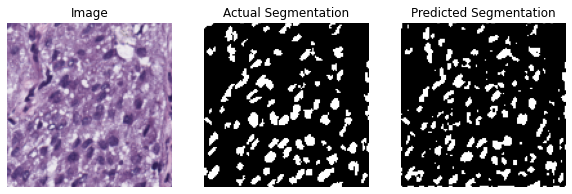

Dice Score for Image 0: 0.7250


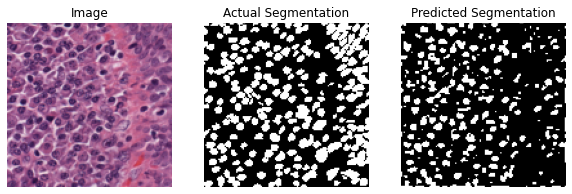

Dice Score for Image 1: 0.6185


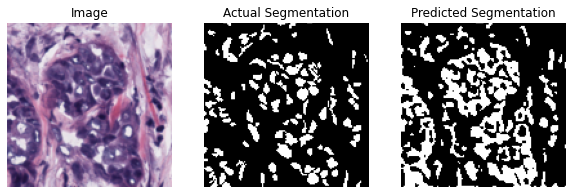

Dice Score for Image 2: 0.6588


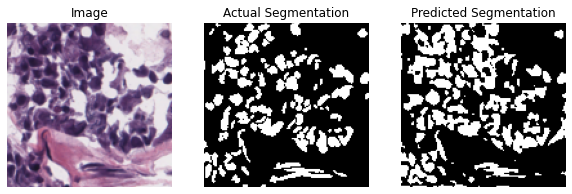

Dice Score for Image 3: 0.7408


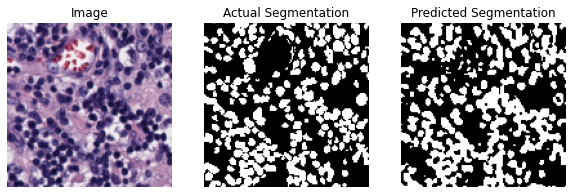

Dice Score for Image 4: 0.7988


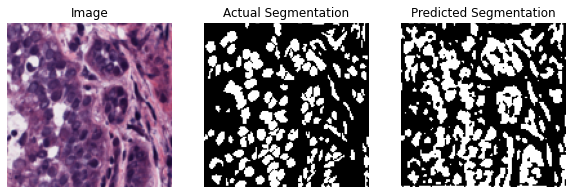

Dice Score for Image 5: 0.7562
Mean Dice Score across all 24 training images: 0.7164


In [66]:
# Select 3 random indices from the training dataset
indices = [0, 10, 20]  # You can change these indices

# Iterate over the selected indices
for i in range(6):
    # Get the image and mask from the training dataset
    img, mask = test_dataset[i]

    # Make a prediction using the trained model
    with torch.no_grad():  # Disable gradient calculation during inference
        prediction = model(img.unsqueeze(0))  # Add batch dimension

    # Threshold the prediction at 0.5 and convert to float tensor
    predicted_mask = (prediction > 0.5).float()

    # Display the image, actual segmentation, and predicted segmentation
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 3, 1)
    displayImg(img)
    plt.title("Image")
    plt.subplot(1, 3, 2)
    displayImg(mask)
    plt.title("Actual Segmentation")
    plt.subplot(1, 3, 3)
    displayImg(predicted_mask.squeeze(0))  # Remove batch dimension
    plt.title("Predicted Segmentation")
    plt.show()

    # Calculate and display the Dice score
    dice = dice_score(predicted_mask, mask)
    print(f"Dice Score for Image {i}: {dice:.4f}")

# Calculate the mean Dice score across all 24 training images
total_dice = 0
for i in range(len(test_dataset)):
    img, mask = test_dataset[i]
    with torch.no_grad():
        prediction = model(img.unsqueeze(0))
    predicted_mask = (prediction > 0.5).float()
    total_dice += dice_score(predicted_mask, mask)

mean_dice = total_dice / len(test_dataset)
print(f"Mean Dice Score across all 24 training images: {mean_dice:.4f}")

